In [213]:
%run ../base_setup.ipynb

Foundation: 2.11.018
Transition: 3.01.005
Engines   : 2.03.028


-------------------------
## Synthetic Builder

In [214]:
builder = SyntheticBuilder.from_env('members')

In [215]:
tools = builder.intent_model

In [216]:
builder.pm.reset_intents()
builder.pm_persist()

In [217]:
sample_size = 1000
df = pd.DataFrame(index=range(sample_size))

-----------
### Distribution elements

In [218]:
# member_id
df['member_id'] = tools.get_number(from_value=100000000, to_value=999999789, at_most=1, size=sample_size, column_name='member_id')
builder.add_column_description(column_name='member_id', description="a unique id for the member")

In [219]:
df = tools.model_sample_map(canonical=df, sample_map='us_persona', female_bias=0.55, column_name='persona')
builder.add_column_description(column_name='persona', description="a base person template")

In [220]:
state_code = ['CA', 'NY', 'LA', 'NJ', 'VA', 'CO', 'NV', 'GA', 'IN', 'OH', 'KY', 'ME', 'MO', 'WI']
df = tools.model_sample_map(canonical=df, sample_map='us_zipcode', state_filter=state_code, column_name='zipcodes')
builder.add_column_description(column_name='zipcodes', description="Only covering 14 states woth a distribution based on population density")

In [221]:
# build up address starting with a number
df['address'] = tools.get_number(from_value=1, to_value=300000, precision=0, relative_freq=[50,10,5,3,2,1,1,1,1,], size=sample_size, column_name='address', intent_order=0)
builder.add_column_description(column_name='address', description="A realistc non-complex address")

In [222]:
# add in a name
df['address'] = tools.correlate_join(df, header='address', sep=' ', action=tools.action2dict(method='get_sample', sample_name='us_street_names', shuffle=True), column_name='address', intent_order=1)

In [223]:
# add road, sep=' ' types
df['address'] = tools.correlate_join(df, header='address', sep=' ', action=tools.action2dict(method='get_sample', sample_name='us_street_types', shuffle=True), column_name='address', intent_order=2)

In [224]:
# has phone number
df['prf_has_phone'] = tools.get_category(selection=[1, 0], relative_freq=[15,1], size=sample_size, column_name='prf_has_phone')
builder.add_column_description(column_name='prf_has_phone', description="If the person has a phone number on record.")

In [225]:
# ensure only thoise with Phone numbers elect to not be called
selection = [builder.tools.select2dict(column='prf_has_phone', condition='@==1')]

action = builder.tools.action2dict(method='get_category', selection=[1, 0], relative_freq=[1,20])
default = builder.tools.action2dict(method='@constant', value=0)

df['prf_not_call'] = builder.tools.correlate_selection(df, selection=selection, action=action, default_action=default, column_name='prf_not_call')
builder.add_column_description(column_name='prf_not_call', description="If the member has elected not to be called. Must have a phone number")

In [226]:
# communication channel preference
channels = ["SydneyCare", "RCP", "Phone", "Email", "SMS", "AgentAssist"]
df['prf_channel_pref'] = tools.get_category(selection=channels, relative_freq=[4,1,3,2,2, 0.1], size=sample_size, column_name='prf_channel_pref', intent_order=-1)
builder.add_column_description(column_name='prf_channel_pref', description="The channel through which the member can be contacted")

In [227]:
# ensure only thoise with sydneycare elkect to be notified
A = builder.tools.select2dict(column='prf_channel_pref', condition="@=='AgentAssist'")
B = builder.tools.select2dict(column='prf_channel_pref', condition="@=='RCP'", logic='AND')
selection = [[A, B], 'NOT']

action = builder.tools.action2dict(method='get_category', selection=[1, 0], relative_freq=[1,50])
default = builder.tools.action2dict(method='@constant', value=0)

df['prf_service_only'] = builder.tools.correlate_selection(df, selection=selection, action=action, default_action=default, column_name='prf_service_only')
builder.add_column_description(column_name='prf_service_only', description="If the member has elected to be contacted only for servicing purposes ")

In [228]:
# ensure if the preference is do not call the channel preference is not Phone
selection = [builder.tools.select2dict(column='prf_not_call', condition='@==1'),
             builder.tools.select2dict(column='prf_channel_pref', condition="@=='Phone'", logic='AND')]

action = builder.tools.action2dict(method='get_category', selection=["SydneyCare", "RCP", "Email", "SMS", "AgentAssist"], relative_freq=[2,1,2,2,0.1])
default = builder.tools.action2dict(method='@header', header='prf_channel_pref')

df['prf_channel_pref'] = builder.tools.correlate_selection(df, selection=selection, action=action, default_action=default, column_name='prf_channel_pref', intent_order=-1)
builder.add_column_description(column_name='prf_channel_pref', description="ensure that if prf_not_call is true the preference isn't by phone")

In [229]:
# ensure if the member has no phone number the channel preference is not SMS or Phone
selection = [builder.tools.select2dict(column='prf_has_phone', condition='@==0')]

action = builder.tools.action2dict(method='get_category', selection=["SydneyCare", "RCP", "Email", "AgentAssist"], relative_freq=[2,1,2, 0.1])
default = builder.tools.action2dict(method='@header', header='prf_channel_pref')

df['prf_channel_pref'] = builder.tools.correlate_selection(df, selection=selection, action=action, default_action=default, column_name='prf_channel_pref', intent_order=-1)
builder.add_column_description(column_name='prf_channel_pref', description="ensure if the member has no phone number the channel preference is not SMS or Phone")

-----------
### Clinical Analytics

In [230]:
# load the sample dataset to analyse and rename columns
clinical_health = 'https://assets.datacamp.com/production/repositories/628/datasets/444cdbf175d5fbf564b564bd36ac21740627a834/diabetes.csv'
builder.add_connector_uri('clinical_health', uri=clinical_health)
df_clinical = builder.load_canonical('clinical_health')
col_names = [f"{'' if name == 'age' else 'cln_'}{name}" for name in df_clinical.columns]
df_clinical.columns = col_names

In [231]:
# create the analytics blob
columns_list=[{'age': {'dtype': 'int', 'precision': 0, 'granularity': 10.0, 'lower': 21, 'upper': 90, }}, 
              {'cln_diabetes': {'dtype': 'category'}},              
              {'cln_pregnancies': {'precision': 0, 'granularity': 2, }, 'cln_glucose': {'precision': 0, 'granularity': 2}, 
               'cln_diastolic': {'precision': 0, 'granularity': 2}, 'cln_triceps': {'precision': 0, 'granularity': 2, 'exclude_dominant': True}, 
               'cln_insulin': {'precision': 0, 'granularity': 2, 'exclude_dominant': True}, 'cln_bmi': {'precision': 1, 'granularity': 3}, 
               'cln_dpf': {'precision': 3, 'granularity': 2}}]
analysis_blob = Transition.from_memory().discover.analyse_association(df_clinical, columns_list=columns_list)

In [232]:
# change the age distribution of the analysis blob
analysis_blob.get('age').get('insight').get('patterns').get('relative_freq')
analysis_blob.get('age').get('insight').get('patterns')['relative_freq'] = [23, 20, 14, 8, 4, 2, 0.4]
analysis_blob.get('age').get('insight').get('patterns').get('relative_freq')

[54.3, 20.44, 14.71, 7.03, 3.26, 0.13, 0.13]

[23, 20, 14, 8, 4, 2, 0.4]

In [233]:
# build the veracity model and create the synthetised results 
df = tools.model_analysis(df, analytics_model=analysis_blob, apply_bias=True, column_name='clinical')
builder.add_column_description(column_name='clinical', description="a section of clinical data taken from the sample reseach dataset on Diabetes")

In [234]:
df['cln_aptmt_dt'] = tools.get_datetime(start=-380, until=-15, relative_freq=[1,2,3,5,7,11], size=sample_size, date_format="%Y-%m-%d", column_name='cln_aptmt_dt')
builder.add_column_description(column_name='cln_aptmt_dt', description="The date of the appointment when the last clinical health data was taken")

In [235]:
# Adjust the pregnancies so there are no male
selection = [builder.tools.select2dict(column='gender', condition="@ =='M'")]

default = tools.action2dict(method='@header', header='cln_pregnancies')

df['cln_pregnancies'] = tools.correlate_selection(df, selection=selection, action=0, default_action=default, column_name='cln_pregnancies', intent_order=1)
builder.add_column_description(column_name='cln_pregnancies', description="Adjustment to ensure no males are have a value")

In [236]:
# check no males were pregnant
((df['cln_pregnancies'].values > 0) & (df['gender'] == 'M')).sum()

0

<AxesSubplot:xlabel='age', ylabel='Density'>

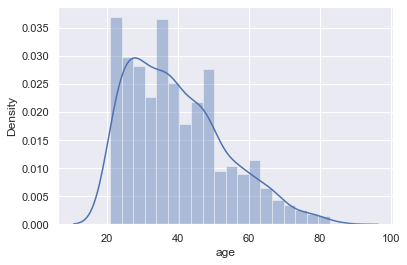

In [237]:
sns.set()
sns.distplot(df['age'], bins=20)

-------------------------
### Healthcare Segments

In [238]:
# member health plan
df['member_health_plan'] = tools.get_category(selection=['PPO', 'HMO'], relative_freq=[6, 4], size=sample_size, column_name='member_health_plan')
builder.add_column_description(column_name='member_health_plan', description="The member health plan")

In [239]:
# healthcare segment 
segment = ["Local Group", "National Accounts", "Medicaid", "BlueCard", "FEP", "Individual"]
df['segment'] = tools.get_category(selection=segment, relative_freq=[38, 19, 18, 15, 4, 2], size=sample_size, column_name='segment', intent_order=0)
builder.add_column_description(column_name='segment', description="The heathcare segment of the member with bias weighting")

In [240]:
# Adjust age for medicare being over 65
selection = [builder.tools.select2dict(column='age', condition='@ >= 65')]

action = tools.action2dict(method='get_category', selection=['Medicare', "Local Group", "National Accounts", "Medicaid"], relative_freq=[99, 0.8, 0.1, 0.1])
default = tools.action2dict(method='@header', header='segment')

df['segment'] = tools.correlate_selection(df, selection=selection, action=action, default_action=default, column_name='segment', intent_order=1)

In [241]:
# # line of buisness
correlations = [["Medicaid", "Medicare"]]
actions = {0: tools.action2dict(method='@constant', value='Business')}

df['line_of_business'] = tools.correlate_categories(df, header='segment', correlations=correlations, actions=actions, default_action='Commercial', column_name='line_of_business')
builder.add_column_description(column_name='line_of_business', description="The line of business this segment is in")

In [242]:
# remove some emails addresses for over 60's
selection = [builder.tools.select2dict(column='age', condition='@ >= 60')]

action = builder.tools.action2dict(method='get_category', selection=[1, 0], relative_freq=[50, 1])

df['prf_has_email'] = builder.tools.correlate_selection(df, selection=selection, action=action, default_action=1, column_name='prf_has_email')
builder.add_column_description(column_name='prf_has_email', description="If the member has an email address on record")

In [243]:
# match the email to the prf_has_email
selection = [builder.tools.select2dict(column='prf_has_email', condition='@ == 0')]

action = tools.action2dict(method='@constant', value="")
default = tools.action2dict(method='@header', header='email')

df['email'] = builder.tools.correlate_selection(df, selection=selection, action=action, default_action=default, column_name='email')
builder.add_column_description(column_name='email', description="trimming those with email address for over 60s from the persona emails")

-------------------------
### Flu Vaccine

In [244]:
# Flu vaccine ICD
df['ins_icd_10_code'] = tools.get_category(selection=['Z23', 'Z28', '0'], relative_freq=[4.5, 1.5, 4], size=sample_size, column_name='ins_icd_10_code', intent_order=0)
builder.add_column_description(column_name='ins_icd_10_code', description="The ICD codes for flu vaccination, Z23 - charable vaccine, Z28 - refused vaccine")

In [245]:
# adjust flu shot for over 65
selection = [builder.tools.select2dict(column='age', condition='@>=65')]

action = builder.tools.action2dict(method='get_category', selection=['Z23', 'Z28', '0'], relative_freq=[6.5, 1, 2.5])
default = builder.tools.action2dict(method='@header', header='ins_icd_10_code')

df['ins_icd_10_code'] = builder.tools.correlate_selection(df, selection=selection, action=action, default_action=default, column_name='ins_icd_10_code', intent_order=1)

In [246]:
# adjust flu shot for under 49
selection = [builder.tools.select2dict(column='age', condition='@<=49')]

action = builder.tools.action2dict(method='get_category', selection=['Z23', 'Z28', '0'], relative_freq=[3, 1, 6])
default = builder.tools.action2dict(method='@header', header='ins_icd_10_code')

df['ins_icd_10_code'] = builder.tools.correlate_selection(df, selection=selection, action=action, default_action=default, column_name='ins_icd_10_code', intent_order=2)

In [247]:
# Flu vaccine CPT
df['ins_cpt_code'] = tools.get_category(selection=['90674', '90682', '90686', '90688', '90694', '90756'], relative_freq=[13, 7, 1, 0.5, 0.1, 0.01], size=sample_size, column_name='ins_cpt_code', intent_order=0)
builder.add_column_description(column_name='ins_cpt_code', description="The CPT codes for flu vaccination, Z23 - charable vaccine, Z28 - refused vaccine")

In [248]:
# adjust flu shot for over 75
selection = [builder.tools.select2dict(column='age', condition='@>=65')]

action = builder.tools.action2dict(method='get_category', selection=['90653', '90662'], relative_freq=[13, 7])
default = builder.tools.action2dict(method='@header', header='ins_cpt_code')

df['ins_cpt_code'] = builder.tools.correlate_selection(df, selection=selection, action=action, default_action=default, column_name='ins_cpt_code', intent_order=1)

In [249]:
# adjust previous flu shot for under 49
selection = [builder.tools.select2dict(column='age', condition='@<=49')]

action = builder.tools.action2dict(method='get_category', selection=['90672', '90674', '90682', '90686'], relative_freq=[13, 7, 3, 1])
default = builder.tools.action2dict(method='@header', header='ins_cpt_code')

df['ins_cpt_code'] = builder.tools.correlate_selection(df, selection=selection, action=action, default_action=default, column_name='ins_cpt_code', intent_order=2)

In [250]:
# Those on Medicare should have a specific code
selection = [builder.tools.select2dict(column='segment', condition="@=='Medicare'"),
            builder.tools.select2dict(column='ins_icd_10_code', condition="@=='Z23'", logic='AND')]

action = builder.tools.action2dict(method='@constant', value='G0008')
default = builder.tools.action2dict(method='@header', header='ins_cpt_code')

df['ins_cpt_code'] = builder.tools.correlate_selection(df, selection=selection, action=action, default_action=default, column_name='ins_cpt_code', intent_order=3)

In [251]:
# those with no ICD code should have no CPT
selection = [builder.tools.select2dict(column='ins_icd_10_code', condition="@!='Z23'")]

action = builder.tools.action2dict(method='@constant', value='0')
default = builder.tools.action2dict(method='@header', header='ins_cpt_code')

df['ins_cpt_code'] = builder.tools.correlate_selection(df, selection=selection, action=action, default_action=default, column_name='ins_cpt_code', intent_order=4)

In [252]:
# add a date in if ICD is Z23
selection = [builder.tools.select2dict(column='ins_icd_10_code', condition="@=='Z23'")]

action = builder.tools.action2dict(method='get_datetime', start=-380, until=-180, relative_freq=[20, 10, 5, 1], ignore_time=True, date_format='%Y-%m-%d')
default = builder.tools.action2dict(method='@constant', value='')

df['ins_cpt_dt'] = builder.tools.correlate_selection(df, selection=selection, action=action, default_action=default, column_name='ins_cpt_dt')
builder.add_column_description(column_name='ins_cpt_dt', description="if had a previous flu shot, a date between 300 and 600 days previous to today")


### Asign a PCP to each member

In [253]:
# assign PCP tax_id
sample_data = tools.action2dict(method='model_sample_map', canonical=tools.action2dict(method='@empty'), sample_map='us_healthcare_practitioner', headers=['city', 'pcp_tax_id'], shuffle=False)
merge_data = tools.action2dict(method='model_group', canonical=sample_data, headers='pcp_tax_id', group_by='city', aggregator='list')
df = tools.model_merge(df, merge_data, how='left', left_on='city', right_on='city', column_name='pcp_tax_id')
builder.add_column_description(column_name='pcp_tax_id', description="Taken from the sample healthcare practitioners, matches a city to a practitioner list")

In [254]:
# select one of the options from the pcp_tax_id list
df['pcp_tax_id'] = tools.correlate_choice(df, header='pcp_tax_id', list_size=1, random_choice=True, shuffle=False, column_name='pcp_tax_id')

In [255]:
# is PCP auto assigned where there is a pc_tax_id
selection = [builder.tools.select2dict(column='pcp_tax_id', condition='@.isna()')]

df['is_PCP_auto_assigned'] = tools.correlate_selection(df, selection=selection, action=0, default_action=1, column_name='is_PCP_auto_assigned')
builder.add_column_description(column_name='is_PCP_auto_assigned', description="if the PCP has been auto assigned with a 7/3 positive distribution")

### Run Reports

In [256]:
builder.canonical_report(df)

,Attributes (36),dType,%_Null,%_Dom,Count,Unique,Observations
0,address,object,0.0%,0.1%,1000,1000,Sample: 15592 Feathergrass Expressway | 22891 Cottage Orchid Expressway | 17534 HighlHills Square | ...
1,age,int64,0.0%,3.9%,1000,62,max=86 | min=21 | mean=39.75 | dominant=21
2,city,object,0.0%,1.1%,1000,838,Sample: Los Angeles | New York | Lexington | San Diego | Atlanta
3,cln_aptmt_dt,object,0.0%,1.4%,1000,299,Sample: 2020-12-19 | 2021-01-22 | 2020-12-17 | 2020-12-13 | 2020-11-27
4,cln_bmi,float64,0.0%,2.0%,1000,299,max=56.8 | min=0.1 | mean=32.03 | dominant=19.6
5,cln_diabetes,int64,0.0%,59.8%,1000,2,max=1 | min=0 | mean=0.4 | dominant=0
6,cln_diastolic,int64,0.0%,2.7%,1000,109,max=121 | min=0 | mean=75.76 | dominant=0
7,cln_dpf,float64,0.0%,1.9%,1000,642,max=2.2 | min=0.081 | mean=0.57 | dominant=0.832
8,cln_glucose,int64,0.0%,2.9%,1000,179,max=197 | min=0 | mean=124.33 | dominant=119
9,cln_insulin,float64,0.0%,53.5%,1000,271,max=801.0 | min=0.0 | mean=83.14 | dominant=0.0


In [257]:
builder.report_column_catalog()

,column_name,description
0,address,A realistc non-complex address
1,clinical,a section of clinical data taken from the sample reseach dataset on Diabetes
2,cln_aptmt_dt,The date of the appointment when the last clinical health data was taken
3,cln_pregnancies,Adjustment to ensure no males are have a value
4,email,trimming those with email address for over 60s from the persona emails
5,ins_cpt_code,"The CPT codes for flu vaccination, Z23 - charable vaccine, Z28 - refused vaccine"
6,ins_cpt_dt,"if had a previous flu shot, a date between 300 and 600 days previous to today"
7,ins_icd_10_code,"The ICD codes for flu vaccination, Z23 - charable vaccine, Z28 - refused vaccine"
8,is_PCP_auto_assigned,if the PCP has been auto assigned with a 7/3 positive distribution
9,line_of_business,The line of business this segment is in


## Run the Pipeline  save the Schema and show the Canonical Report

In [258]:
# run the pipeline
builder.run_synthetic_pipeline(size=sample_size)

# report the stored schema
builder.canonical_report(builder.load_synthetic_canonical(), stylise=True)

,Attributes (36),dType,%_Null,%_Dom,Count,Unique,Observations
0,address,object,0.0%,0.1%,1000,1000,Sample: 10460 Us 183 Svrd Nb At Fm 1327 Groves | 22778 Lost Spring Circle | 22520 Perch Trailer | 94...
1,age,int64,0.0%,4.0%,1000,62,max=91 | min=21 | mean=38.58 | dominant=23
2,city,object,0.0%,1.6%,1000,836,Sample: Los Angeles | New York | Sacramento | Columbus | Colorado Springs
3,cln_aptmt_dt,object,0.0%,1.6%,1000,299,Sample: 2020-12-18 | 2020-12-03 | 2020-12-25 | 2020-11-27 | 2021-01-10
4,cln_bmi,float64,0.0%,2.2%,1000,303,max=64.4 | min=1.0 | mean=31.9 | dominant=19.6
5,cln_diabetes,int64,0.0%,59.9%,1000,2,max=1 | min=0 | mean=0.4 | dominant=0
6,cln_diastolic,int64,0.0%,2.5%,1000,113,max=121 | min=0 | mean=75.42 | dominant=76
7,cln_dpf,float64,0.0%,1.9%,1000,666,max=2.281 | min=0.08 | mean=0.64 | dominant=0.832
8,cln_glucose,int64,0.0%,2.4%,1000,182,max=198 | min=0 | mean=124.52 | dominant=119
9,cln_insulin,float64,0.0%,53.5%,1000,298,max=824.0 | min=0.0 | mean=89.24 | dominant=0.0


In [259]:
builder.load_synthetic_canonical().head(5)

,member_id,prf_has_phone,cln_aptmt_dt,member_health_plan,first_name,middle_name,gender,family_name,email,city,state_abbr,state,county_fips,county,zipcode,age,cln_diabetes,cln_pregnancies,cln_glucose,cln_diastolic,cln_triceps,cln_insulin,cln_bmi,cln_dpf,pcp_tax_id,address,prf_not_call,prf_channel_pref,prf_service_only,segment,line_of_business,prf_has_email,ins_icd_10_code,ins_cpt_code,ins_cpt_dt,is_PCP_auto_assigned
0,772599842,1,2021-01-12,HMO,Xandria,Massiah,F,Ellam,xandria.ellam@charter.net,Greencastle,MO,Missouri,29211,Sullivan,63544,53,1,7,14,14,42.000,0.000,52.200,0.572,371307317.000,16205 Ault Hucknall Key,0,Phone,0,Local Group,Commercial,1,0,0,,1
1,435399921,1,2020-03-11,PPO,Yinuo,Cardale,F,Lese,yinuo.lese@facebook.com,Silver Creek,NY,New York,36013,Chautauqua,14136,34,0,4,74,76,35.000,199.000,27.100,0.678,607518112.000,30236 Wilmington Corners,0,SydneyCare,0,Local Group,Commercial,1,Z23,90672,2020-03-10,1
2,865899820,1,2020-03-06,HMO,Dexton,Paylen,M,Paytas,dexton.paytas@hushmail.com,Tappan,NY,New York,36087,Rockland,10964,47,0,0,150,94,7.000,56.000,25.000,0.412,886743680.000,26983 N Lamar Sb To W 15Th Camp,0,Phone,0,National Accounts,Commercial,1,0,0,,1
3,431199922,1,2021-01-14,PPO,Khaleed,Breckan,M,Cushwa,khaleed.cushwa@ymail.com,Krakow,WI,Wisconsin,55115,Shawano,54137,23,0,0,171,79,23.000,238.000,21.100,0.766,NaN,253625 Endless Shore Court,0,Email,0,BlueCard,Commercial,1,Z23,90672,2020-02-16,0
4,150999988,1,2020-06-12,PPO,Gila,Ryler,F,Carlstrom,gila.carlstrom@ymail.com,Sun,LA,Louisiana,22103,St. Tammany,70463,46,0,2,3,32,41.000,0.000,51.700,0.086,NaN,28702 Sutton Courtenay Center,1,SydneyCare,0,Local Group,Commercial,1,0,0,,0


-------------------------
-------------------------
## Members Transition

In [260]:
tr = Transition.from_env('members')

In [261]:
tr.pm.reset_intents()
tr.pm_persist()

In [262]:
df = tr.load_source_canonical()

In [263]:
# clean the data
tr.cleaners.auto_clean_header(df, inplace=True)
tr.cleaners.auto_transition(df, inplace=True)
tr.cleaners.to_str_type(df, dtype='object', inplace=True)
tr.cleaners.to_str_type(df, headers=['address', 'city', 'county', 'state', 'first_name', 'family_name', 'middle_name', 'email'], use_string_type=True, inplace=True)
tr.cleaners.to_remove(df, headers=['county_fips'], inplace=True)
tr.cleaners.to_remove(df, regex=['cln_', 'prf_', 'ins_'], inplace=True)

In [264]:
tr.upload_attributes(builder.report_column_catalog(stylise=False), label_key='column_name', text_key='description', constraints=list(df.columns))

## Run the Pipeline  save the Schema and show the Schema Report

In [265]:
# run the pipeline
tr.run_transition_pipeline()

# report the stored schema
tr.canonical_report(tr.load_clean_canonical(), stylise=True)

,Attributes (19),dType,%_Null,%_Dom,Count,Unique,Observations
0,address,string,0.0%,0.1%,1000,1000,Sample: 10460 Us 183 Svrd Nb At Fm 1327 Groves | 22778 Lost Spring Circle | 22520 Perch Trailer | 94...
1,age,int64,0.0%,4.0%,1000,62,max=91 | min=21 | mean=38.58 | dominant=23
2,city,string,0.0%,1.6%,1000,836,Sample: Los Angeles | New York | Sacramento | Columbus | Colorado Springs
3,county,string,0.0%,4.1%,1000,377,Sample: Los Angeles | Suffolk | Jefferson | Orange | Hamilton
4,county_fips,int64,0.0%,4.1%,1000,469,max=55141 | min=6001 | mean=26013.68 | dominant=6037
5,email,string,0.2%,0.2%,1000,999,Sample: tarique.uva@googlemail.com | indika.demoya@email.com | uyiosa.fogelquist@yandex.com | ermina...
6,family_name,string,0.0%,0.2%,1000,994,Sample: Fraley | Patryn | Sandbo | Melnikov | Crilly
7,first_name,string,0.0%,0.2%,1000,998,Sample: Edith | Scotti | Cascia | Ahlayah | Geremy
8,gender,category,0.0%,55.0%,1000,2,Sample: F | M
9,is_PCP_auto_assigned,bool,0.0%,69.1%,1000,2,True | False


-------------------------
-------------------------
## Clinical Members Transition

In [266]:
tr = Transition.from_env('cln_members')

In [267]:
tr.pm.reset_intents()
tr.pm_persist()

In [268]:
df = tr.load_source_canonical()

In [269]:
# clean the data
tr.cleaners.auto_clean_header(df, inplace=True)
tr.cleaners.auto_transition(df, inplace=True)
tr.cleaners.to_str_type(df, dtype='object', inplace=True)
tr.cleaners.to_date_type(df, headers='ins_cpt_dt', inplace=True)
tr.cleaners.to_select(df, regex=['cln_', 'member_id'], inplace=True)

In [270]:
tr.upload_attributes(builder.report_column_catalog(stylise=False), label_key='column_name', text_key='description', constraints=list(df.columns))

## Run the Pipeline  save the Schema and show the Schema Report

In [271]:
# run the pipeline
tr.run_transition_pipeline()

# report the stored schema
tr.canonical_report(tr.load_clean_canonical(), stylise=True)

,Attributes (10),dType,%_Null,%_Dom,Count,Unique,Observations
0,cln_aptmt_dt,datetime64[ns],0.0%,1.6%,1000,299,max=2021-01-26 00:00:00 | min=2020-01-28 00:00:00 | yr mean= 2020
1,cln_bmi,float64,0.0%,2.2%,1000,303,max=64.4 | min=1.0 | mean=31.9 | dominant=19.6
2,cln_diabetes,bool,0.0%,59.9%,1000,2,True | False
3,cln_diastolic,int64,0.0%,2.5%,1000,113,max=121 | min=0 | mean=75.42 | dominant=76
4,cln_dpf,float64,0.0%,1.9%,1000,666,max=2.281 | min=0.08 | mean=0.64 | dominant=0.832
5,cln_glucose,int64,0.0%,2.4%,1000,182,max=198 | min=0 | mean=124.52 | dominant=119
6,cln_insulin,float64,0.0%,53.5%,1000,298,max=824.0 | min=0.0 | mean=89.24 | dominant=0.0
7,cln_pregnancies,int64,0.0%,51.1%,1000,17,max=16 | min=0 | mean=2.62 | dominant=0
8,cln_triceps,float64,0.0%,34.5%,1000,64,max=87.0 | min=0.0 | mean=19.89 | dominant=0.0
9,member_id,int64,0.0%,0.1%,1000,1000,"max=997899789 | min=100000000 | mean=547074294.68 | dominant=[100000000, 100299999]"


-------------------------
-------------------------
## Preference Members Transition

In [272]:
tr = Transition.from_env('prf_members')

In [273]:
tr.pm.reset_intents()
tr.pm_persist()

In [274]:
df = tr.load_source_canonical()

In [275]:
# clean the data
tr.cleaners.auto_clean_header(df, inplace=True)
tr.cleaners.auto_transition(df, inplace=True)
tr.cleaners.to_str_type(df, dtype='object', inplace=True)
tr.cleaners.to_select(df, regex=['prf_', 'member_id'], inplace=True)

In [276]:
tr.upload_attributes(builder.report_column_catalog(stylise=False), label_key='column_name', text_key='description', constraints=list(df.columns))

## Run the Pipeline  save the Schema and show the Schema Report

In [277]:
# run the pipeline
tr.run_transition_pipeline()

# report the stored schema
tr.canonical_report(tr.load_clean_canonical(), stylise=True)

,Attributes (6),dType,%_Null,%_Dom,Count,Unique,Observations
0,member_id,int64,0.0%,0.1%,1000,1000,"max=997899789 | min=100000000 | mean=547074294.68 | dominant=[100000000, 100299999]"
1,prf_channel_pref,category,0.0%,34.8%,1000,6,Sample: SydneyCare | Phone | Email | SMS | RCP
2,prf_has_email,bool,0.0%,99.8%,1000,2,True | False
3,prf_has_phone,bool,0.0%,94.5%,1000,2,True | False
4,prf_not_call,bool,0.0%,95.8%,1000,2,False | True
5,prf_service_only,bool,0.0%,97.8%,1000,2,False | True


-------------------------
-------------------------
## Insurance Claims Members Transition

In [278]:
tr = Transition.from_env('ins_members')

In [279]:
tr.pm.reset_intents()
tr.pm_persist()

In [280]:
df = tr.load_source_canonical()

In [281]:
# clean the data
tr.cleaners.auto_clean_header(df, inplace=True)
tr.cleaners.auto_transition(df, inplace=True)
tr.cleaners.to_str_type(df, dtype='object', inplace=True)
tr.cleaners.to_select(df, regex=['ins_', 'member_id'], inplace=True)

In [282]:
tr.upload_attributes(builder.report_column_catalog(stylise=False), label_key='column_name', text_key='description', constraints=list(df.columns))

## Run the Pipeline  save the Schema and show the Schema Report

In [283]:
# run the pipeline
tr.run_transition_pipeline()

# report the stored schema
tr.canonical_report(tr.load_clean_canonical(), stylise=True)

,Attributes (4),dType,%_Null,%_Dom,Count,Unique,Observations
0,ins_cpt_code,category,0.0%,66.1%,1000,7,Sample: 0 | 90672 | 90674 | 90682 | G0008
1,ins_cpt_dt,object,66.1%,66.1%,1000,130,Sample: 2020-02-22 | 2020-02-14 | 2020-03-12 | 2020-02-16 | 2020-02-12
2,ins_icd_10_code,category,0.0%,55.5%,1000,3,Sample: 0 | Z23 | Z28
3,member_id,int64,0.0%,0.1%,1000,1000,"max=997899789 | min=100000000 | mean=547074294.68 | dominant=[100000000, 100299999]"
